# Wise Sliding Window Segmentation: A classification-aided approach for trajectory segmentation

## Experiments on part of geolife dataset

If you are using this code please cite the following paper:

@article{etemadwise,
  title={Wise Sliding Window Segmentation: A classification-aided approach for trajectory segmentation},
  author={Etemad, Mohammad and Etemad, Zahra and Soares, Am{\i}lcar and Bogorny, Vania and Matwin12, Stan and Torgo, Luis}
}
[The arxiv version of the paper is available here](https://arxiv.org/abs/2003.10248)

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
import numpy as np
from core.random_walk import random_walk
from core.linear import linear
from core.cubic import cubic
from core.kinematic import kinematic
interpolations = [random_walk, cubic, linear, kinematic]
interpolation_names = ['Random Walk', 'cubic', 'linear', 'kinematic']
window_size=7

listoffiles=['./db/geolife/geolife_w_features_1.csv'
            ,'./db/geolife/geolife_w_features_2.csv'
            ,'./db/geolife/geolife_w_features_3.csv'
            ,'./db/geolife/geolife_w_features_4.csv'
            ,'./db/geolife/geolife_w_features_5.csv'
            ,'./db/geolife/geolife_w_features_6.csv'
            ,'./db/geolife/geolife_w_features_7.csv'
            ,'./db/geolife/geolife_w_features_8.csv'
            ,'./db/geolife/geolife_w_features_9.csv',
             './db/geolife/geolife_w_features_10.csv']




def read_fold(file_name,new_columns_names):
    df1 = pd.read_csv(file_name, sep=',', parse_dates=['time'])
    df1 = df1.sort_index()
    df1.rename(columns=new_columns_names, inplace=True)
    tsid_ = df1.lid * 10000 
    df_fold1 = df1.assign(tsid=tsid_)
    df_fold1.sort_values(by=['tsid', 'time'], inplace=True)
    return df_fold1.copy()

def clean_df(df_test,window_size):
    # remove all segments shorter than windows_size+1
    
    dic={}
    l=[]
    dfff=df_test.copy()
    for i in set(df_test.tsid):
        if df_test.iloc[np.where(np.array(df_test.tsid)==i)[0],:].shape[0]<=window_size+1:
            dic[i]=df_test.iloc[np.where(np.array(df_test.tsid)==i)[0],:].shape[0]
            l.append(i)
    df_test=df_test[~df_test.tsid.isin(l)].copy()
    return df_test

def purity( ground_truth, labels):
    #ground_truth=label
    avg = []
    ground_truth = np.array(ground_truth)
    labels = np.array(labels)

    for ts in set(labels):
        ma = 0
        g = ground_truth[(np.where(labels == ts)[0])]
        for tp in set(g):
            _ = len(np.where(g == tp)[0])
            if _ > ma:
                ma = _
        # do not involve noise
        if ts != -1:
            #print(ma,len(g),str(ma * 1.0 / len(g)))
            avg.append(ma * 1.0 / len(g))
    return avg, np.mean(np.array(avg))

def coverage( ground_truth, labels):
    #ground_truth=tsid
    cov = []
    labels = np.array(labels)
    ground_truth = np.array(ground_truth)

    for ts in set(ground_truth):
        mx = 0
        g = labels[(np.where(ground_truth == ts)[0])]
        for l in set(g):
            _ = len(np.where(g == l)[0])
            if mx<=_:
                mx=_
        cov.append(mx * 1.0 / len(g))
    return cov, np.mean(np.array(cov))


def calculate_error(df, f1=None, rang=(0, 0), window_size=7):
    start = rang[0]
    if rang[1] == 0:
        limit = df.shape[0]
    else:
        limit = rang[1]
    end = limit
    ln=int(window_size/2)
    da=[0]*ln
    print(window_size,"dd",da)
    for ix in range(end - start - window_size):
        try:
            seven_points = df.iloc[start + ix:start + ix + window_size, :]
            lat = seven_points.lat.values
            lon = seven_points.lon.values
            p1, p2, pc, d = f1(seven_points)
        except:
            d = 0
        da.append(d)
        
    for i in range(ln+1):
        da.append(0)
    print(window_size,"dd",da[-10:])
    return da

def generate_error_signal( df,window_size, interpolation_name='Random Walk'):

    f = interpolation_names.index(interpolation_name)
    res = {}
    means_res = {}

    da = calculate_error(df, f1=interpolations[f], rang=(0, 0),window_size=window_size)
    res[interpolation_names[f]] = da
    means_res[interpolation_names[f]] = np.nanmax(da)
    da[0:int(window_size/2)]=[da[int(window_size/2)]]*int(window_size/2)
    da[len(da)-1*int(window_size/2)-1:len(da)]=[da[len(da)-int(window_size/2)-2]]*(int(window_size/2)+1)

    return da

def signal_to_sample(e_signal,sid,window_size=7):
    r=[]
    X_train=[]
    y_train=[]
    for i in range(0,len(e_signal)-window_size):
        r.append([e_signal[i:i+window_size],np.sign(len(set(sid[i:i+window_size]))-1)])
        X_train.append(e_signal[i:i+window_size])
        y_train.append([np.sign(len(set(sid[i:i+window_size]))-1)])
    y_train=pd.DataFrame(y_train)
    X_train=pd.DataFrame(X_train)
    return X_train,np.array( y_train).ravel()

def check_traj(a,label,verbose=False):
    bad=0
    x=a[0]
    start=0
    j=0
    for i in range(len(a)):
        if x==a[i]:
            pass
        else:
            if verbose:
                print("[",start,",",i,"]",i-start,label[start])
            if i-start<=window_size:
                if verbose:
                    print("***")
                bad=bad+i-start
                j=j+1
            x=a[i]
            start=i+1
    if verbose:
        print("[",start,",",len(a),"]",len(a)-start,label[start])
    print("***:",j)
    print("quality:",int((len(a)-bad)/len(a)*100))
    

def majority_vote(res,window_size=7,degree=0.9):
    start=0
    segid=1
    nsegid=-1
    segmentid=[]
    for i in range(int(window_size/2)+1,len(res)-int(window_size/2)):
         if(np.sum(res[i-int(window_size/2):i+int(window_size/2)+1])>=int(window_size*degree)):
            
            if i-start<=window_size:

                segmentid=segmentid+[nsegid]*(i-start)
                nsegid=nsegid-1
                start=i
      
            else:
                segmentid=segmentid+[segid]*(i-start+1)
                segid=segid+1
                start=i+1

    segmentid=segmentid+[segid]*(len(res)-start)
    return np.array(segmentid)

In [5]:
def experiment(window_size,degree=0.9):
    j=0 #train file id
    rang=set(range(len(listoffiles)))
    hmm=[]
    pmm=[]
    cmm=[]
    for i in rang:
        train_file=listoffiles[j] 
        print(i,j, "train file:",train_file)
        df=read_fold(file_name=train_file,new_columns_names={'latitude': 'lat','longitude': 'lon',
                                                             'transportation_mode':'label'})
        df=clean_df(df,window_size) #clean short segments
        a=np.array(df.tsid)
        l=df.label
        check_traj(a,l)
        print("length of training data:",df.shape)
        e_signal=generate_error_signal( df,window_size)
        print("length of error signal:",len(e_signal))

        X_train, y_train=signal_to_sample(e_signal=e_signal,sid=df.tsid,window_size=window_size)
        print(X_train.shape,y_train.shape)

        rf=RandomForestClassifier( n_estimators=100)
        rf.fit(X_train, y_train)
        acc=[]
        hm=[]
        pm=[]
        cm=[]
        for k in rang-set([j]):
            test_file=listoffiles[k]
            df_test=read_fold(file_name=test_file,new_columns_names={'latitude': 'lat','longitude': 'lon',
                                                             'transportation_mode':'label'})
            df_test=clean_df(df_test,window_size) #clean short segments

            e_signal_test=generate_error_signal( df_test,window_size)
            X_test, y_test=signal_to_sample(e_signal=e_signal_test,sid=df_test.tsid,window_size=window_size)

            y_pred=rf.predict(X_test)
            y_pred=np.array(list([y_pred[0]]*int(window_size/2))+list(y_pred)+list([y_pred[-1]]*(int(window_size/2)+1)))
            score = rf.score(X_test, y_test)
            acc.append(int(100*score))

            segmentid=majority_vote(y_pred,window_size=window_size,degree=degree)
            
            pur=purity(ground_truth=df_test.label,labels=segmentid)[1]
            cov=coverage(ground_truth=df_test.tsid,labels=segmentid)[1]
            #print("\tPurity:",pur)
            #print("\tCoverage:",cov)
            h=2*pur*cov/(pur+cov)
            hm.append(100*h)
            pm.append(100*pur)
            cm.append(100*cov)
            print("\tHarmonic mean:",h)
            #print(list(zip(segmentid,df_test.tsid)))
        print("\t",k, "harmonic mean avg:",np.mean(hm),hm)
        print("\t",k, "Accuracy of Binary classifier:",acc)
        j=j+1
        hmm.append(np.mean(hm))
        pmm.append(np.mean(pm))
        cmm.append(np.mean(cm))
    print(np.mean(hmm),np.std(hmm),hmm)
    return hmm,np.mean(hmm),np.std(hmm),pmm,np.mean(pmm),np.std(pmm),cmm,np.mean(cmm),np.std(cmm)

In [6]:
parameters={'window_sizes':[5,7,9,11,13],'degree':[0.6,0.9]}
res={}
pres={}
cres={}
res_mean={}
res_std={}
for d in parameters['degree']:
    for ws in parameters['window_sizes']:
        print(d,ws)
        hmm,hmm_mean,hmm_std,pmm,pmm_mean,pmm_std,cmm,cmm_mean,cmm_std=experiment(ws,d)
        res[d,ws]=hmm
        pres[d,ws]=pmm
        cres[d,ws]=cmm
        res_mean[d,ws]=hmm_mean
        res_std[d,ws]=hmm_std
print("done")

0.6 5
0 0 train file: ./db/geolife/geolife_w_features_1.csv
***: 0
quality: 100
length of training data: (972, 18)
5 dd [0, 0]
5 dd [432.060617728026, 1019.5388261521294, 210.50910977248333, 203.45659277562214, 389.97507432132323, 337.0460300166221, 169.5376637189224, 0, 0, 0]
length of error signal: 972
(967, 5) (967,)
5 dd [0, 0]
5 dd [108.73083534769684, 77.55622859696095, 15.764132242212563, 25.96069843824483, 26.290127751712077, 32.84986093747917, 82.67071010451023, 0, 0, 0]
	Harmonic mean: 0.8618158397347515
5 dd [0, 0]
5 dd [947.1193177311795, 202.00559608284993, 285.2920345390509, 414.2530437812746, 102.07000068929594, 150.11657158944521, 1510.146002578047, 0, 0, 0]
	Harmonic mean: 0.9542203345290504
5 dd [0, 0]
5 dd [32.78422576683278, 53.03137507153127, 0.7039069600980572, 37.53137674789197, 5.244786877717916, 6.23541155085282, 3.328202822490838, 0, 0, 0]
	Harmonic mean: 0.8647926760950513
5 dd [0, 0]
5 dd [10.047422419985624, 6.68336849038589, 22.330045278354298, 5.389324604

	Harmonic mean: 0.9871937866397794
5 dd [0, 0]
5 dd [7.687701543179153, 19.7886253528747, 17.563884587515265, 6.5657514435998365, 5.526545022503429, 2.7453213540163657, 4.95525407484109, 0, 0, 0]
	Harmonic mean: 0.8475783475783477
5 dd [0, 0]
5 dd [0.2762433579596548, 0.33712812146789295, 0.6694806831907592, 0.8226575334397015, 2.9516755869775237, 3.197986267617422, 3.7416254664297233, 0, 0, 0]
	Harmonic mean: 0.9437410976227694
5 dd [0, 0]
5 dd [6.381807155653311, 92.48111354272335, 55.13535153775139, 36.67938044734907, 115.73246246913706, 19.95105981603418, 98.1256658445282, 0, 0, 0]
	Harmonic mean: 0.8675589024351169
5 dd [0, 0]
5 dd [2.3886751836522073, 36.88353155502367, 26.803862008566323, 5.119024678471844, 4.717195826983808, 3.2114167306726507, 7.285270278524689, 0, 0, 0]
	Harmonic mean: 0.9316898649947292
5 dd [0, 0]
5 dd [0.5594007884340967, 0.3791185474342064, 1.320467697379201, 1.8955824736210274, 0.4311187168720536, 1.095820861784479, 1.185590613233006, 0, 0, 0]
	Harmonic 

5 dd [10.160685403151342, 20.65405228851319, 11.011963098814242, 19.727668377559432, 40.913276460677864, 42.26250819674272, 78.06047337886744, 0, 0, 0]
length of error signal: 2584
(2579, 5) (2579,)
5 dd [0, 0]
5 dd [35.797194785082084, 585.0206438946016, 93.73604714829594, 217.2405089702263, 405.7849591704929, 355.64227859813235, 131.26416281635136, 0, 0, 0]
	Harmonic mean: 0.7391340490413868
5 dd [0, 0]
5 dd [27.565984002066358, 52.484046449938845, 59.03072605395713, 30.149417182457253, 67.46815900157593, 71.17176191875636, 30.314173716269465, 0, 0, 0]
	Harmonic mean: 0.9540397408240198
5 dd [0, 0]
5 dd [841.3825730791307, 113.1808704175071, 187.08680645665967, 46.759098193918376, 168.80120898756041, 338.11163036441036, 564.7565945316109, 0, 0, 0]
	Harmonic mean: 0.8700137809402785
5 dd [0, 0]
5 dd [7.095524089858405, 19.90781472664343, 14.313573621160913, 7.000946599394655, 4.15679260093165, 6.73033963627639, 1.3270499659705353, 0, 0, 0]
	Harmonic mean: 0.8827165681863536
5 dd [0, 0

	Harmonic mean: 0.9500830321383217
7 dd [0, 0, 0]
7 dd [13.744379578309125, 12.056445714886218, 25.143154298266236, 9.935221202687911, 7.415967821890396, 10.474969367185999, 0, 0, 0, 0]
	Harmonic mean: 0.8475783475783477
7 dd [0, 0, 0]
7 dd [0.24512415992882977, 0.6524041740813854, 0.3836116260262101, 1.1793262972150997, 0.27075730563976097, 1.193905435479314, 0, 0, 0, 0]
	Harmonic mean: 0.6492134831460674
7 dd [0, 0, 0]
7 dd [28.46152330594628, 68.56965949014105, 15.40580838859919, 50.35646558392545, 54.085456199332505, 68.29095377741058, 0, 0, 0, 0]
	Harmonic mean: 0.9346545376679922
7 dd [0, 0, 0]
7 dd [41.049391093417285, 7.265852999042571, 31.86379071147956, 27.688631718118856, 10.393276074229188, 8.349975596350776, 0, 0, 0, 0]
	Harmonic mean: 0.8152731013766479
7 dd [0, 0, 0]
7 dd [0.4278948471051123, 1.3035184830683442, 1.3460106096690032, 0.7912483086858206, 2.1465755691826716, 1.3965656635573311, 0, 0, 0, 0]
	Harmonic mean: 0.89174732552216
	 9 harmonic mean avg: 87.7523819645

(5367, 7) (5367,)
7 dd [0, 0, 0]
7 dd [503.7629237317185, 607.9683965459119, 679.5752706559241, 61.906991698076816, 535.8359731292987, 240.3556454813709, 0, 0, 0, 0]
	Harmonic mean: 0.8040669227381909
7 dd [0, 0, 0]
7 dd [78.87571577767753, 27.079244778907405, 78.5839214686841, 15.769858477653889, 73.69176818403571, 51.95312260983763, 0, 0, 0, 0]
	Harmonic mean: 0.9347578828632517
7 dd [0, 0, 0]
7 dd [1119.5159043875876, 1002.871181126133, 426.5767746013578, 405.84287392181704, 400.99673653571296, 554.7544577956407, 0, 0, 0, 0]
	Harmonic mean: 0.8568584799587954
7 dd [0, 0, 0]
7 dd [25.600298229156163, 11.881563595910496, 27.062131256153762, 20.780363610123228, 3.7859775807033804, 3.671302377631549, 0, 0, 0, 0]
	Harmonic mean: 0.8339068527583294
7 dd [0, 0, 0]
7 dd [20.613952835409286, 10.548241077112886, 11.151567345920327, 13.221112129486949, 27.640454974862486, 11.851528691880302, 0, 0, 0, 0]
	Harmonic mean: 0.8998179049369487
7 dd [0, 0, 0]
7 dd [0.7561990668213265, 0.9673424860827

	Harmonic mean: 0.8170719864762592
7 dd [0, 0, 0]
7 dd [1.2729161244848457, 0.5266644051277775, 0.27445447680493057, 0.7628336145492469, 1.5135778212868523, 0.7021301353477499, 0, 0, 0, 0]
	Harmonic mean: 0.956756239561447
	 9 harmonic mean avg: 88.83145653214893 [70.1125313667417, 96.26815367999416, 84.2064631953532, 79.87274402116518, 99.12461029879202, 96.8963426406867, 95.61944098283675, 81.70719864762592, 95.67562395614469]
	 9 Accuracy of Binary classifier: [60, 91, 91, 91, 94, 98, 96, 94, 97]
8 8 train file: ./db/geolife/geolife_w_features_9.csv
***: 0
quality: 100
length of training data: (1166, 18)
7 dd [0, 0, 0]
7 dd [26.20570900761862, 14.418527086929519, 42.369426891194315, 4.704000919189413, 6.942375453673636, 6.498234974706725, 0, 0, 0, 0]
length of error signal: 1166
(1159, 7) (1159,)
7 dd [0, 0, 0]
7 dd [251.69312534357553, 377.84904832383177, 656.7771046245247, 487.034392814166, 291.6552742852206, 320.75674920808257, 0, 0, 0, 0]
	Harmonic mean: 0.9733821814423882
7 dd 

	Harmonic mean: 0.9867648156112319
9 dd [0, 0, 0, 0]
9 dd [27.590652783029814, 15.704302985741915, 16.2472766342114, 19.75904142003513, 12.199678412116636, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9594909100620764
9 dd [0, 0, 0, 0]
9 dd [0.7076130607156013, 1.2312336807620528, 0.7293154772906401, 0.5503186857662998, 2.1934262377720883, 0, 0, 0, 0, 0]
	Harmonic mean: 0.953038757042165
9 dd [0, 0, 0, 0]
9 dd [18.76762194685897, 25.396702845392955, 66.6985220020632, 57.91561582397584, 26.340259869373348, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9629648462220923
9 dd [0, 0, 0, 0]
9 dd [40.35536552426633, 2.7129021127515833, 4.55557156603938, 52.54474480194286, 4.893863068337857, 0, 0, 0, 0, 0]
	Harmonic mean: 0.7784700210059535
9 dd [0, 0, 0, 0]
9 dd [0.13440072881636891, 1.2426371635802949, 2.513308255420116, 2.0134641897320904, 4.036820873318709, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9503291867537832
	 9 harmonic mean avg: 85.76711198315178 [62.028965791779015, 72.73839888271405, 78.03078950414269, 98.676481

	Harmonic mean: 0.5328508471238552
9 dd [0, 0, 0, 0]
9 dd [10.129093709644074, 44.091395674010265, 21.4079271886037, 46.24222291267894, 5.837783491036109, 0, 0, 0, 0, 0]
	Harmonic mean: 0.5799741197531265
9 dd [0, 0, 0, 0]
9 dd [38.45184015885459, 9.889793275801875, 32.39656416918622, 22.279610314481392, 2.1738691325897053, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9798688481882286
9 dd [0, 0, 0, 0]
9 dd [0.39586067058122393, 1.2533344828318163, 0.855312785786256, 0.0932312537509078, 1.0438802018811242, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9531471949655409
9 dd [0, 0, 0, 0]
9 dd [53.309749207971265, 113.40917277620994, 70.25804060816779, 86.89042145692235, 40.189433602597624, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9158357186218282
9 dd [0, 0, 0, 0]
9 dd [9.365211160782716, 9.495883951657495, 22.010902286030955, 52.698058051190266, 7.872425711207052, 0, 0, 0, 0, 0]
	Harmonic mean: 0.6984699197682522
9 dd [0, 0, 0, 0]
9 dd [0.3978197468469885, 1.0310180345885496, 1.790135326907607, 0.6462458412701533, 1.02

	Harmonic mean: 0.9502361634541199
9 dd [0, 0, 0, 0]
9 dd [129.67289402084262, 235.6650346449999, 709.7343012780058, 121.46627068444187, 229.60947634918213, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9356944545604593
9 dd [0, 0, 0, 0]
9 dd [20.548519924689995, 24.537990381316952, 5.864356888317908, 35.185654428239296, 3.447199368922174, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9191429446628406
9 dd [0, 0, 0, 0]
9 dd [31.16445950044457, 17.45340700092278, 33.584241140416964, 17.450734109055475, 27.054270651074088, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9953443136985944
9 dd [0, 0, 0, 0]
9 dd [3.6704044302599366, 13.002005396260204, 12.336903812561765, 18.025927003220815, 9.892747988691434, 0, 0, 0, 0, 0]
	Harmonic mean: 0.8475783475783477
9 dd [0, 0, 0, 0]
9 dd [0.4163602364679603, 1.7046955423322976, 0.2876708711247817, 1.879866890870381, 2.9999311035680374, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9646939580819966
9 dd [0, 0, 0, 0]
9 dd [34.38944501990332, 150.2485740793613, 33.614051515712035, 81.14385610721035, 42

11 dd [39.69159245357586, 89.03616955845324, 64.66579927118417, 42.93512743992387, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9646331557662929
11 dd [0, 0, 0, 0, 0]
11 dd [672.7712300040563, 349.2608386278332, 442.96159798078315, 269.71597388654, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.868980569019327
11 dd [0, 0, 0, 0, 0]
11 dd [8.934812196800511, 17.243986459991792, 22.762804599783728, 19.847311199274444, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9874782457241711
11 dd [0, 0, 0, 0, 0]
11 dd [43.24589253681506, 11.13412014568783, 18.22535903851724, 2.9434185591366524, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.970501751096455
11 dd [0, 0, 0, 0, 0]
11 dd [0.4469926570643119, 0.6455446392872766, 0.6293970437707088, 1.6921996454392398, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9501432496185083
11 dd [0, 0, 0, 0, 0]
11 dd [7.834601545077339, 13.832282925277198, 40.387554815152924, 36.18584123284796, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9677530587326804
11 dd [0, 0, 0, 0, 0]
11 dd [58.19109784863998, 15.427142162117821,

	Harmonic mean: 0.6805370627175487
11 dd [0, 0, 0, 0, 0]
11 dd [56.45317773495576, 14.388159895928156, 7.877462639149124, 9.563886336710132, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.7252751648614038
11 dd [0, 0, 0, 0, 0]
11 dd [4.799632056290241, 3.847143955389755, 37.30552700399444, 25.79504390124593, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9856425758744464
11 dd [0, 0, 0, 0, 0]
11 dd [26.143794612930982, 11.598029265403035, 16.90347589089392, 11.706927294653626, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9668845476372483
11 dd [0, 0, 0, 0, 0]
11 dd [0.7321805710397078, 0.18269463305344982, 0.7479965583191045, 2.083173049128886, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9384325467134229
11 dd [0, 0, 0, 0, 0]
11 dd [51.5894549903145, 54.58512277356836, 26.219906491504297, 4.158998903726832, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.7530118311161326
11 dd [0, 0, 0, 0, 0]
11 dd [1.0726174148720267, 2.651219344704167, 1.8320114563058887, 2.3405019554935262, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9494548022306097
	 9 ha

13 dd [9.112496397544605, 31.38742745396553, 7.393624516066628, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9735529906134114
13 dd [0, 0, 0, 0, 0, 0]
13 dd [1.0398017713156413, 0.8198342717930814, 0.3963931191339545, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9391518283252989
13 dd [0, 0, 0, 0, 0, 0]
13 dd [69.52221476991299, 87.85996840082277, 26.428291907865727, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.964863383808819
13 dd [0, 0, 0, 0, 0, 0]
13 dd [22.677680312787015, 42.49321102267007, 22.763883672551664, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.7745762252641545
13 dd [0, 0, 0, 0, 0, 0]
13 dd [1.9253228262509057, 1.306575606133652, 1.7991008183826938, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9408528134642159
	 9 harmonic mean avg: 85.33654613661227 [63.041910860623716, 74.10509247414771, 73.02852373104758, 98.55366401610134, 97.35529906134114, 93.9151828325299, 96.4863383808819, 77.45762252641545, 94.0852813464216]
	 9 Accuracy of Binary classifier: [59, 88, 91, 90, 95, 94, 84, 92, 95]
2 2 train 

13 dd [0.7570036720953178, 1.293348928880447, 1.6293107433954641, 0, 0, 0, 0, 0, 0, 0]
length of error signal: 5975
(5962, 13) (5962,)
13 dd [0, 0, 0, 0, 0, 0]
13 dd [411.7111906146312, 298.3307435933931, 444.7933324812092, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.4545628055542318
13 dd [0, 0, 0, 0, 0, 0]
13 dd [30.426611901985954, 62.672040397567365, 42.344846136358555, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.8291583472954516
13 dd [0, 0, 0, 0, 0, 0]
13 dd [367.9738098868316, 241.72838352338317, 694.0910185536094, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.42798041685559834
13 dd [0, 0, 0, 0, 0, 0]
13 dd [51.2623161201549, 43.640034357426885, 35.80774945909242, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.5932647771360859
13 dd [0, 0, 0, 0, 0, 0]
13 dd [30.90796181542653, 14.673158200139444, 8.26448486354245, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9659629046975248
13 dd [0, 0, 0, 0, 0, 0]
13 dd [29.488989572284773, 44.22487023769623, 2.2798135531030317, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.92103

	Harmonic mean: 0.8261859431160947
5 dd [0, 0]
5 dd [23.02044251953549, 12.441711007341688, 44.553909547151164, 6.924514391703028, 1.2758989879693952, 5.094343644056324, 5.1686897675161, 0, 0, 0]
	Harmonic mean: 0.8134223237297683
5 dd [0, 0]
5 dd [5.5309987620577505, 5.965273477036534, 49.046638548313645, 50.79987134574113, 14.568197827311359, 14.688021804800593, 4.5040865471770815, 0, 0, 0]
	Harmonic mean: 0.9750938246332309
5 dd [0, 0]
5 dd [12.892027083388593, 17.18848490679508, 10.567698552310393, 17.829204923132988, 21.09119306977779, 3.5623152175379027, 11.963489138428148, 0, 0, 0]
	Harmonic mean: 0.8475783475783477
5 dd [0, 0]
5 dd [0.7081580631420191, 0.5629637625747883, 1.1927429149026825, 0.7066644886379769, 2.4707585445994424, 2.9647360046212974, 2.829531440485052, 0, 0, 0]
	Harmonic mean: 0.7499150446425316
5 dd [0, 0]
5 dd [72.81071307441393, 18.778589823108188, 35.161487006637635, 51.71885975068654, 28.260081544596364, 67.67345744712847, 116.92616345849353, 0, 0, 0]
	Har

5 dd [4.864998497560408, 23.64971214799058, 23.377305588284063, 6.7431356651183725, 6.193239412816372, 2.359377019211595, 3.265020830647781, 0, 0, 0]
	Harmonic mean: 0.9132881975621677
5 dd [0, 0]
5 dd [1.0741424563684543, 1.26417826754211, 2.4416359285977243, 0.735858586616059, 0.918774795982412, 1.6666445361417956, 0.2698186233517232, 0, 0, 0]
	Harmonic mean: 0.9260052244666316
	 9 harmonic mean avg: 86.52059880438392 [89.84349562559402, 73.6538224380645, 92.16945075276759, 98.28529243985102, 84.75783475783477, 78.28559586803891, 77.76055515442451, 91.32881975621677, 92.60052244666316]
	 9 Accuracy of Binary classifier: [86, 93, 97, 96, 98, 97, 93, 97, 98]
4 4 train file: ./db/geolife/geolife_w_features_5.csv
***: 0
quality: 100
length of training data: (5374, 18)
5 dd [0, 0]
5 dd [4.1896061360199335, 3.8335705684085224, 50.615863071765084, 102.58125964676263, 22.26636174019642, 5.515995961824695, 1.7488020485346223, 0, 0, 0]
length of error signal: 5374
(5369, 5) (5369,)
5 dd [0, 0]

5 dd [0, 0]
5 dd [56.79002199551266, 42.5896825668082, 74.68692300076803, 42.35065946161766, 34.65054770853334, 69.5942703662776, 87.64509467616969, 0, 0, 0]
	Harmonic mean: 0.8892077477376918
5 dd [0, 0]
5 dd [329.58932397136977, 401.4570552853606, 141.74667580544886, 330.1943431685958, 131.2898254981715, 456.4664494513011, 943.0773551258366, 0, 0, 0]
	Harmonic mean: 0.8463058151612665
5 dd [0, 0]
5 dd [18.25571748714781, 40.325070842148925, 14.932311014220938, 29.422435508190702, 5.992015705386915, 2.531532833042667, 2.0700619924471, 0, 0, 0]
	Harmonic mean: 0.8419202659687162
5 dd [0, 0]
5 dd [13.529595939338853, 8.87943054498207, 5.513130230517265, 63.1311957398888, 28.37311608991734, 42.65094043101439, 0.6560009071576199, 0, 0, 0]
	Harmonic mean: 0.980090599644968
5 dd [0, 0]
5 dd [7.257402255084479, 15.687963871590709, 2.5452280305984565, 14.86950047437837, 14.967886726911804, 25.457210178914046, 17.493953354988044, 0, 0, 0]
	Harmonic mean: 0.9657480669442309
5 dd [0, 0]
5 dd [0.

	Harmonic mean: 0.6492134831460674
7 dd [0, 0, 0]
7 dd [65.98369307680828, 124.02046597087617, 56.51152537203167, 54.553043327445515, 51.38661005503335, 77.07037679647223, 0, 0, 0, 0]
	Harmonic mean: 0.8100391434492287
7 dd [0, 0, 0]
7 dd [1.5916547172928612, 35.304007183760376, 38.34028874082034, 8.208889140294236, 11.443606747191929, 10.013374621934545, 0, 0, 0, 0]
	Harmonic mean: 0.6217494089834515
7 dd [0, 0, 0]
7 dd [1.8539367307501424, 0.6574015222243492, 0.7063990276256817, 0.3439394363701025, 1.2553215949423133, 0.6822687736472155, 0, 0, 0, 0]
	Harmonic mean: 0.89174732552216
	 9 harmonic mean avg: 78.58373214834053 [77.76055515442451, 82.88446114915772, 69.56749894972481, 95.00830321383216, 84.75783475783477, 64.92134831460675, 81.00391434492286, 62.174940898345156, 89.174732552216]
	 9 Accuracy of Binary classifier: [90, 96, 94, 94, 97, 94, 90, 95, 98]
1 1 train file: ./db/geolife/geolife_w_features_12.csv
***: 0
quality: 100
length of training data: (2584, 9)
7 dd [0, 0, 0]


	Harmonic mean: 0.9105013851884136
7 dd [0, 0, 0]
7 dd [339.09571611466254, 650.7753093310375, 378.4489302275599, 302.86218734112043, 75.60789844611877, 742.5566850844198, 0, 0, 0, 0]
	Harmonic mean: 0.898170940431923
7 dd [0, 0, 0]
7 dd [33.49631939678254, 13.559997361123157, 29.689731052559242, 6.50993011739805, 24.15523026830317, 2.6438717732925228, 0, 0, 0, 0]
	Harmonic mean: 0.9018210881235758
7 dd [0, 0, 0]
7 dd [17.91720650316701, 6.209137303768591, 17.722309608906958, 8.447887870495487, 19.52925785687982, 20.105963132931553, 0, 0, 0, 0]
	Harmonic mean: 0.9412759285329286
7 dd [0, 0, 0]
7 dd [0.436907244957916, 0.9643176500969408, 1.274469072608089, 1.1796095061614402, 1.4576846178666105, 1.2826924559767363, 0, 0, 0, 0]
	Harmonic mean: 0.8656611985917881
7 dd [0, 0, 0]
7 dd [129.28215508652053, 61.88325032751656, 53.93521178478205, 44.642776474289676, 59.819313925528334, 34.25309457606252, 0, 0, 0, 0]
	Harmonic mean: 0.9277237301203247
7 dd [0, 0, 0]
7 dd [9.66417567459066, 23.3

7 dd [55.78052663815165, 9.651779465912721, 14.846359726406416, 14.382071896479752, 20.919297955452258, 5.058494870098075, 0, 0, 0, 0]
length of error signal: 1166
(1159, 7) (1159,)
7 dd [0, 0, 0]
7 dd [403.38631006650115, 197.35644165790902, 668.971802686685, 890.004270415768, 414.13635839285894, 258.2516714687298, 0, 0, 0, 0]
	Harmonic mean: 0.9035880864802739
7 dd [0, 0, 0]
7 dd [64.95147267953303, 26.442267469811117, 82.40956977999969, 19.593571517338866, 17.814163368872435, 84.4378682149445, 0, 0, 0, 0]
	Harmonic mean: 0.8112580574673386
7 dd [0, 0, 0]
7 dd [284.3650203694452, 676.9997287508847, 479.1278999397494, 462.78816356179686, 417.1021057735349, 304.7554837198654, 0, 0, 0, 0]
	Harmonic mean: 0.8730728619842169
7 dd [0, 0, 0]
7 dd [13.178633310935291, 8.10243794345747, 10.825825273392832, 6.021397616830452, 16.270565143795356, 14.691681732422584, 0, 0, 0, 0]
	Harmonic mean: 0.5816603364080304
7 dd [0, 0, 0]
7 dd [24.198022628632774, 43.94367124475975, 10.550837127289261, 43.

9 dd [87.90907022485555, 12.078485576435158, 3.80877132978785, 18.420240938572455, 8.858555536089376, 0, 0, 0, 0, 0]
	Harmonic mean: 0.8937296504003183
9 dd [0, 0, 0, 0]
9 dd [1.2487955977378322, 0.8360037052726568, 1.1129686325516506, 0.16132648401560554, 1.7190588490598473, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9375291303092018
	 9 harmonic mean avg: 90.5131510212651 [73.86405444634667, 91.80230607282554, 89.4951126437849, 99.46322215028222, 91.25992725648075, 93.23570929139649, 92.37214925931735, 89.37296504003183, 93.75291303092018]
	 9 Accuracy of Binary classifier: [59, 91, 92, 93, 97, 95, 89, 93, 97]
2 2 train file: ./db/geolife/geolife_w_features_13.csv
***: 0
quality: 100
length of training data: (5245, 9)
9 dd [0, 0, 0, 0]
9 dd [394.49653351966776, 283.99952783958565, 392.23798302476746, 267.1766011857899, 272.7835501047458, 0, 0, 0, 0, 0]
length of error signal: 5245
(5236, 9) (5236,)
9 dd [0, 0, 0, 0]
9 dd [186.7964328264821, 526.688818247717, 188.09755532428147, 847.51954061555

	Harmonic mean: 0.9337734772334401
9 dd [0, 0, 0, 0]
9 dd [57.29273278946537, 99.4323931693237, 85.08606056548996, 79.1637828877694, 53.03872933693944, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9414244684954788
9 dd [0, 0, 0, 0]
9 dd [9.183153211444006, 18.275401693750602, 7.847639555062822, 37.09864963130728, 5.92245253216723, 0, 0, 0, 0, 0]
	Harmonic mean: 0.7711406426680025
9 dd [0, 0, 0, 0]
9 dd [2.853075963087671, 1.1723965301235264, 2.2017590673265404, 1.2952196642701481, 0.2866474609428059, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9273401445863992
	 9 harmonic mean avg: 85.93703210806933 [66.16283836198662, 91.62364816492217, 80.43165711009311, 78.36060562791397, 99.48666640937606, 93.377347723344, 94.14244684954788, 77.11406426680026, 92.73401445863992]
	 9 Accuracy of Binary classifier: [55, 86, 77, 91, 93, 95, 87, 92, 97]
6 6 train file: ./db/geolife/geolife_w_features_17.csv
***: 0
quality: 100
length of training data: (6001, 9)
9 dd [0, 0, 0, 0]
9 dd [0.503651363520401, 0.15628733412589377,

	Harmonic mean: 0.9750061139642945
9 dd [0, 0, 0, 0]
9 dd [19.581282651887822, 29.24254888959338, 10.759634487965174, 30.864276499738818, 10.979554814714943, 0, 0, 0, 0, 0]
	Harmonic mean: 0.8475783475783477
9 dd [0, 0, 0, 0]
9 dd [0.5019195471987022, 0.37320297651831097, 1.152935395209955, 1.4484660153905051, 3.0556073462559956, 0, 0, 0, 0, 0]
	Harmonic mean: 0.6499437570303712
9 dd [0, 0, 0, 0]
9 dd [63.70405590174907, 90.88379239359875, 77.2555314892855, 31.162215456007505, 46.484756081275805, 0, 0, 0, 0, 0]
	Harmonic mean: 0.7732145790253772
9 dd [0, 0, 0, 0]
9 dd [28.10244794244324, 5.584126555110295, 17.80170715598289, 35.17729733091955, 9.470720332488556, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9207466104093237
	 8 harmonic mean avg: 84.8065028661102 [84.19709581178593, 77.32145790253772, 96.7150135288107, 88.3760177510861, 97.50061139642945, 84.75783475783477, 64.99437570303712, 77.32145790253772, 92.07466104093237]
	 8 Accuracy of Binary classifier: [69, 87, 96, 93, 93, 96, 93, 87, 9

	Harmonic mean: 0.84979766722209
11 dd [0, 0, 0, 0, 0]
11 dd [0.8971675147195531, 0.2828346698920376, 1.1139270975197368, 0.046066071065764484, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9532988146155003
11 dd [0, 0, 0, 0, 0]
11 dd [33.89816446263181, 45.065743450031526, 77.25645755487439, 102.91564104992372, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9055122252657395
11 dd [0, 0, 0, 0, 0]
11 dd [54.61971687337425, 21.329448799853267, 6.282574243057259, 20.995246918249183, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9125113649473068
11 dd [0, 0, 0, 0, 0]
11 dd [1.326904652626424, 2.95494767716715, 0.5698015651292837, 1.5094906733628464, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9567660981298535
	 9 harmonic mean avg: 91.95053213434191 [87.22363901521702, 88.98673466796845, 95.31908649371826, 98.23671201412448, 84.979766722209, 95.32988146155003, 90.55122252657395, 91.25113649473067, 95.67660981298535]
	 9 Accuracy of Binary classifier: [69, 85, 91, 91, 96, 94, 85, 94, 96]
4 4 train file: ./db/geolife/geolife_w_fe

11 dd [0.5895680366686424, 0.280592578538678, 1.3363035283744031, 1.6178161805591929, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9589297549134987
11 dd [0, 0, 0, 0, 0]
11 dd [10.38505151777455, 31.604235543334052, 3.8185892747716332, 23.07294143258907, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.827261785741336
11 dd [0, 0, 0, 0, 0]
11 dd [1.9379424377769192, 2.1342357149105506, 1.828718975558421, 1.3391597584339585, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.947356022725946
	 9 harmonic mean avg: 88.50479821832869 [68.5089594680331, 91.10623927356366, 84.38595608200916, 82.66131649270476, 99.19043918659408, 97.3355171239753, 95.89297549134987, 82.7261785741336, 94.7356022725946]
	 9 Accuracy of Binary classifier: [60, 86, 87, 91, 91, 96, 94, 91, 96]
8 8 train file: ./db/geolife/geolife_w_features_9.csv
***: 0
quality: 100
length of training data: (1157, 18)
11 dd [0, 0, 0, 0, 0]
11 dd [34.658183144248525, 31.78056179758783, 25.22857913977342, 3.4673654593690086, 0, 0, 0, 0, 0, 0]
length of error signal: 11

	Harmonic mean: 0.8341493194993722
13 dd [0, 0, 0, 0, 0, 0]
13 dd [2.446432442775384, 0.8504361334511435, 1.1154980729917654, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.943681376971772
	 9 harmonic mean avg: 88.55750326736137 [69.10872730053099, 80.04552200791554, 83.14954167736727, 99.20146121353322, 96.54342210530041, 95.84895643369666, 95.33682902079387, 83.41493194993723, 94.3681376971772]
	 9 Accuracy of Binary classifier: [58, 85, 90, 90, 95, 93, 85, 91, 95]
2 2 train file: ./db/geolife/geolife_w_features_13.csv
***: 0
quality: 100
length of training data: (5207, 9)
13 dd [0, 0, 0, 0, 0, 0]
13 dd [296.08830232441534, 449.28178028130793, 402.1823218793705, 0, 0, 0, 0, 0, 0, 0]
length of error signal: 5207
(5194, 13) (5194,)
13 dd [0, 0, 0, 0, 0, 0]
13 dd [575.2806529203285, 356.34072302886244, 10.382477067841688, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.8403335406301282
13 dd [0, 0, 0, 0, 0, 0]
13 dd [66.20666386029741, 30.928504078056104, 70.605237347706, 0, 0, 0, 0, 0, 0, 0]
	Harmonic

13 dd [0, 0, 0, 0, 0, 0]
13 dd [39.44565256796594, 364.6935713329207, 80.81378678577552, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.44410801240115744
13 dd [0, 0, 0, 0, 0, 0]
13 dd [11.754148486091776, 21.052290285799632, 30.274939346173138, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9053452624111603
13 dd [0, 0, 0, 0, 0, 0]
13 dd [281.9662539234482, 479.68980273454724, 681.5728670960037, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.4846355769841804
13 dd [0, 0, 0, 0, 0, 0]
13 dd [69.31827116382732, 27.049523962453584, 20.55050155233175, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.7018953284601355
13 dd [0, 0, 0, 0, 0, 0]
13 dd [45.87946352182869, 21.45575065037959, 25.610527092519504, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9918527621427702
13 dd [0, 0, 0, 0, 0, 0]
13 dd [26.406799638798766, 37.62568675200936, 21.119862403706136, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9460690587824144
13 dd [0, 0, 0, 0, 0, 0]
13 dd [53.71686220328293, 104.64519015866551, 45.15357035012186, 0, 0, 0, 0, 0, 0, 0]
	Harmonic 

                     0.6                                             \
                      5          7         9          11         13   
harmonic mean  89.107027  89.173712  87.12448  86.521433  84.911004   

                     0.9                                              
                      5          7          9          11         13  
harmonic mean  86.581396  86.555798  85.268113  88.573852  87.396848  


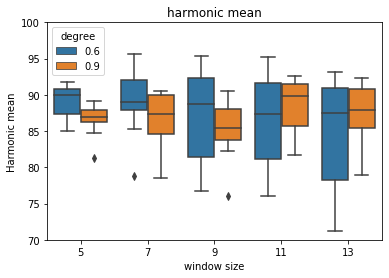

In [7]:
df_res=pd.DataFrame(res)
b = df_res.unstack(level=0).reset_index(level=2, drop=True).reset_index(name='Harmonic mean')
b.rename(columns={'level_0':'degree','level_1':'window size'}, inplace=True)
import seaborn as sns
ax = sns.boxplot(x='window size', y='Harmonic mean', hue="degree",data=b)
plt.ylim(70,100)
df_res_mean=pd.DataFrame(res_mean,index=['harmonic mean'])
print(df_res_mean)
plt.title('harmonic mean')
plt.savefig('wsii_geo.png')

              0.6                                                   0.9  \
               5          7         9          11         13         5    
purity  89.107027  89.173712  87.12448  86.521433  84.911004  86.581396   

                                                    
               7          9          11         13  
purity  86.555798  85.268113  88.573852  87.396848  


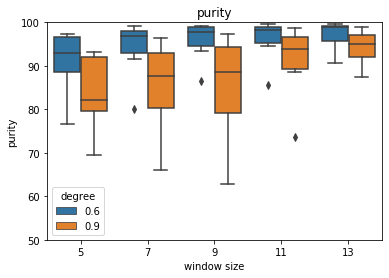

In [11]:
df_res=pd.DataFrame(pres)
b = df_res.unstack(level=0).reset_index(level=2, drop=True).reset_index(name='purity')
b.rename(columns={'level_0':'degree','level_1':'window size'}, inplace=True)
import seaborn as sns
ax = sns.boxplot(x='window size', y='purity', hue="degree",data=b)
plt.ylim(50,100)
df_res_mean=pd.DataFrame(res_mean,index=['purity'])
print(df_res_mean)
plt.title('purity')
plt.savefig('purity_wsii_geo.png')

                0.6                                                   0.9  \
                 5          7         9          11         13         5    
coverage  89.107027  89.173712  87.12448  86.521433  84.911004  86.581396   

                                                      
                 7          9          11         13  
coverage  86.555798  85.268113  88.573852  87.396848  


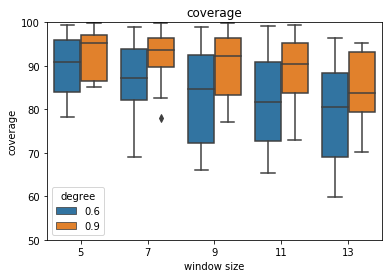

In [12]:
df_res=pd.DataFrame(cres)
b = df_res.unstack(level=0).reset_index(level=2, drop=True).reset_index(name='coverage')
b.rename(columns={'level_0':'degree','level_1':'window size'}, inplace=True)
import seaborn as sns
ax = sns.boxplot(x='window size', y='coverage', hue="degree",data=b)
plt.ylim(50,100)
df_res_mean=pd.DataFrame(res_mean,index=['coverage'])
print(df_res_mean)
plt.title('coverage')
plt.savefig('coverage_wsii_fishing.png')

In [10]:
s=0
u=[]
ts=0
for l in listoffiles:
    df=read_fold(file_name=l,new_columns_names={'latitude': 'lat','longitude': 'lon'})
    #print(l,df.shape[0])
    ks=0
    for k,v in df.groupby(['lid']):
        #print(k,v.shape[0])
        ks=ks+1
    s=s+df.shape[0]
    u.append([ks])
    ts=ts+ks
print("number of trajectory points:",s,"segments in each fold:",u,"Number of segments:",ts)

number of trajectory points: 32095 segments in each fold: [[17], [45], [33], [18], [52], [11], [56], [45], [12], [15]] Number of segments: 304
